
# Running Ensemble Inference

The following notebook demostrates how to use Earth-2 MIP's config schema and builtin
inference workflows to perform ensemmble inference of the FourCastNetv2 small (FCNv2-sm)
weather model with an intial state pulled from the Climate Data Store (CDS) and
perturbed with random noise. The ensemble output will then be loaded into an Xarray
Dataset and some sample data analysis is provided.

In summary this notebook will cover the following topics:

- Configuring and setting up FCNv2 model registry
- An ensemble configuration file
- Running ensemble inference in Earth-2 MIP to produce an xarray DataSet
- Post processing results


## Set Up
Starting off with imports, hopefully you have already installed Earth-2 MIP from this
repository. There are a few additional packages needed.



In [7]:
import json
import os

Prior to importing Earth-2 MIP, users need to be aware of a few enviroment variables
which can be used to customize Earth-2 MIPs global behavior. These must be set prior to
importing Earth-2 MIP. There are a number of different configuration options, some to
consider are:

- `WORLD_SIZE`: Tells Earth-2 MIP (which uses Modulus under the hood) the number of GPUs to use for inferencing.
- `MODEL_REGISTRY`: This variable tells Earth-2 MIP where location the model registery. By default this is located in `${HOME}/.cache/earth2mip/models`.

*Key Concept*: A model registry is a folder that Earth-2 MIP will explore to find model
checkpoints to load. A folder containing the required fileds is referred to as a
"model package". Model packages typically consist of a few files such as:

- `weights.tar`/`weights.mdlus`: the model checkpoint to load
- `metadata.json`: a JSON file that contains meta info regarding various details for using the model
- `config.json`: constains parameters needed to instantiate the model object in python
- `global_means.npy`: A numpy array containing the mean values used for normalization of data in the model
- `global_std.npy`: A numpy array containing the standard deviation values used for normalization of data in the model



In [8]:
import dotenv
import xarray

dotenv.load_dotenv()

# With the enviroment variables set now we import Earth-2 MIP
from earth2mip import inference_ensemble, registry

The cell above created a model registry folder for us, but if this is your first
notebook its likely empty. Lets fix that. As previously metioned we will be using the
FCNv2-sm weather model with the checkpoint provided on the Nvidia Modulus model
registry. The model is shipped via a zip folder containing the required checkpoint files
discussed above.

Since this model is built into Earth-2 MIP, the `registry.get_model` function can be
used to auto-download and extract it (this can take a bit).
The `e2mip://` prefix on the model URI, will point Earth-2 MIP to use the package
fetch methods built into the model.
Without it, Earth-2 MIP will simply look for a `fcnv2_sm` folder in your model registry
and not attempt to download anything for you.
Once complete, go look in your `MODEL_REGISTRY` folder and the files needed for FCNv2
should now be present.



In [9]:
print("Fetching model package...")
package = registry.get_model("e2mip://fcnv2_sm")

Fetching model package...


The final setup step is to set up your CDS API key so we can access ERA5 data to act as
an initial state. Earth-2 MIP supports a number of different initial state data sources
that are supported including HDF5, CDS, GFS, etc. The CDS initial state provides a
convenient way to access a limited amount of historical weather data. Its recommended
for accessing an initial state, but larger data requirements should use locally stored
weather datasets.

Enter your CDS API uid and key below (found under your profile page).
If you don't a CDS API key, find out more here.

- [https://cds.climate.copernicus.eu/cdsapp#!/home](https://cds.climate.copernicus.eu/cdsapp#!/home)
- [https://cds.climate.copernicus.eu/api-how-to](https://cds.climate.copernicus.eu/api-how-to)



In [10]:
cds_api = os.path.join(os.path.expanduser("~"), ".cdsapirc")
if not os.path.exists(cds_api):
    uid = "284286"
    key = "de834125-206a-4678-8c57-7c392d04b52c"
    # Write to config file for CDS library
    with open(cds_api, "w") as f:
        f.write("url: https://cds.climate.copernicus.eu/api/v2\n")
        f.write(f"key: {uid}:{key}\n")

## Running Inference

To run inference we will use the `earth2mip/ensemble_inference.py` part of Earth-2 MIP.
When this Python file, we provide either a config JSON file or a JSON serialized string
for it to parse. This config contains the information regarding how the model should run
inference. The schema of this can be found in `earth2mip/schema/EnsembleRun`.

Since we are working in a notebook, lets create this config Pythonically. There are
quite a few parameters that can be used, but lets focus in on a few key ones:

- `ensemble_members`: Number ensemble members in the forecast

- `noise_amplitude`: The amplitude of the noise pertibation method (we find that a good value to start with is `0.05`, feel free to experiment)

- `simulation_length`: Number of (6h) time-steps to predict

- `weather_event`: This defines the weather event as a combination of an initial time and a domain.

- `output_path`: The output location of the ensemble prediction netCDF file

- `weather_model`: The model ID to run. This MUST match the name of the model registry folder with your checkpoint files. So for this example its `fcnv2_sm`.

<div class="alert alert-info"><h4>Note</h4><p>Note: While in later notebooks we will demonstrate more Pythonic methods to interact
  with Earth-2 MIP's APIs, the built in inference workflows provide a high-degree of
  control with little to no programming.</p></div>



In [11]:
config = {
    "ensemble_members": 4,
    "noise_amplitude": 0.05,
    "simulation_length": 10,
    "weather_event": {
        "properties": {
            "name": "Globe",
            "start_time": "2018-06-01 00:00:00",
            "initial_condition_source": "cds",
        },
        "domains": [
            {
                "name": "global",
                "type": "Window",
                "diagnostics": [{"type": "raw", "channels": ["t2m", "u10m"]}],
            }
        ],
    },
    "output_path": "outputs/01_ensemble_notebook",
    "output_frequency": 1,
    "weather_model": "fcnv2_sm",
    "seed": 12345,
    "use_cuda_graphs": False,
    "ensemble_batch_size": 1,
    "autocast_fp16": False,
    "perturbation_strategy": "correlated",
    "noise_reddening": 2.0,
}

Now we run the `main()` function in `earth2mip.inference_ensemble` providing our config
object which will run inference with the following steps:

1. Instantiate and load the FCNv2 small weather model onto the device
2. Download the initial state data needed from CDS using your saved API key
3. Perturb the initial state based on the parameters in the config and run a forecast predicton
4. Save output Xarray dataset to NetCDF file located in `../outputs/01_ensemble_notebook` (the process may take a while!)



In [12]:
# Option 1: Use config file and CLI (use this outside a notebook)
# with open('./01_config.json', 'w') as f:
#     json.dump(config, f)
# ! python3 -m earth2mip.inference_ensemble 01_config.json

# Option 2: Feed in JSON string directly into main function
config_str = json.dumps(config)
inference_ensemble.main(config_str)

/data/keeling/a/megha4/miniconda3/envs/earth2mip_env/lib/python3.10/site-packages/modulus/distributed/manager.py:329: UserWarning: Distributed manager is already intialized
  warn("Distributed manager is already intialized")
INFO:root:Earth-2 MIP config loaded weather_model='fcnv2_sm' simulation_length=10 perturbation_strategy=<PerturbationStrategy.correlated: 'correlated'> perturbation_channels=None noise_reddening=2.0 noise_amplitude=0.05 output_frequency=1 output_grid=None ensemble_members=4 seed=12345 ensemble_batch_size=1 forecast_name=None weather_event=WeatherEvent(properties=WeatherEventProperties(name='Globe', start_time=datetime.datetime(2018, 6, 1, 0, 0), initial_condition_source=<InitialConditionSource.cds: 'cds'>, netcdf='', restart=''), domains=[Window(type='Window', name='global', lat_min=-90, lat_max=90, lon_min=0, lon_max=360, diagnostics=[Diagnostic(type='raw', function='', channels=['t2m', 'u10m'], nbins=10)])]) output_dir=None output_path='outputs/01_ensemble_notebo

When the inference is complete we can examine the output in `outputs/01_ensemble_notebook/ensemble_out_0.nc`.

Note: if the inference is distributed across N GPUs there will be `ensemble_out_0.nc`, `ensemble_out_1.nc`, ... `ensemble_out_N-1.nc` output files.
In this case a function like this could concat the files to a single xarray DataArray:

```
def _open(f, domain, time, chunks={"time": 1}):
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=lead_time)

def open_ensemble(path, domain, time):
    path = pathlib.Path(path)
    ensemble_files = list(path.glob("ensemble_out_*.nc"))
    return xarray.concat(
      [_open(f, group, time) for f in ensemble_files], dim="ensemble"
    )
```
(TODO: Parallel inference / scoring example)

But with our single NetCDF file we can load it into a [Xarray Dataset](https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html) with just a few lines of code.



In [13]:
def open_ensemble(f, domain, chunks={"time": 1}):
    time = xarray.open_dataset(f).time
    root = xarray.open_dataset(f, decode_times=False)
    ds = xarray.open_dataset(f, chunks=chunks, group=domain)
    ds.attrs = root.attrs
    return ds.assign_coords(time=time)


output_path = config["output_path"]
domains = config["weather_event"]["domains"][0]["name"]
ensemble_members = config["ensemble_members"]
ds = open_ensemble(os.path.join(output_path, "ensemble_out_0.nc"), domains)
ds

<xarray.Dataset> Size: 731MB
Dimensions:  (lat: 721, lon: 1440, ensemble: 4, time: 11)
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8
  * time     (time) datetime64[ns] 88B 2018-06-01 ... 2018-06-03T12:00:00
Dimensions without coordinates: ensemble
Data variables:
    imin     int64 8B ...
    imax     int64 8B ...
    jmin     int64 8B ...
    jmax     int64 8B ...
    t2m      (ensemble, time, lat, lon) float64 365MB dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
    u10m     (ensemble, time, lat, lon) float64 365MB dask.array<chunksize=(2, 1, 361, 720), meta=np.ndarray>
Attributes:
    model:          fcnv2_sm
    config:         {"weather_model": "fcnv2_sm", "simulation_length": 10, "p...
    weather_event:  {"properties": {"name": "Globe", "start_time": "2018-06-0...
    date_created:   2024-09-06T15:30:40.471528
    history:        /data/keeling/a/megha4/miniconda3/envs/earth2mip_env/lib/...
    institution:    NVIDIA
    Conventions:    CF-1.10

## Post Processing
With inference complete, now the fun part: post processing and analysis!
You can manipulate the data to your hearts content now that its in an Xarray Dataset.
Here we will demonstrate some common plotting / analysis workflows one may be
interested. Lets start off with importing all our post processing packages.

(You may need to pip install matplotlib and cartopy)



In [14]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.colors import TwoSlopeNorm

countries = cfeature.NaturalEarthFeature(
    category="cultural",
    name="admin_0_countries",
    scale="50m",
    facecolor="none",
    edgecolor="black",
)

Up first, we can plot a time series of the value of a variable (or statistics of that
variable) at a given location (lat/lon coord). In this case lets look at the results
predicted over New York.



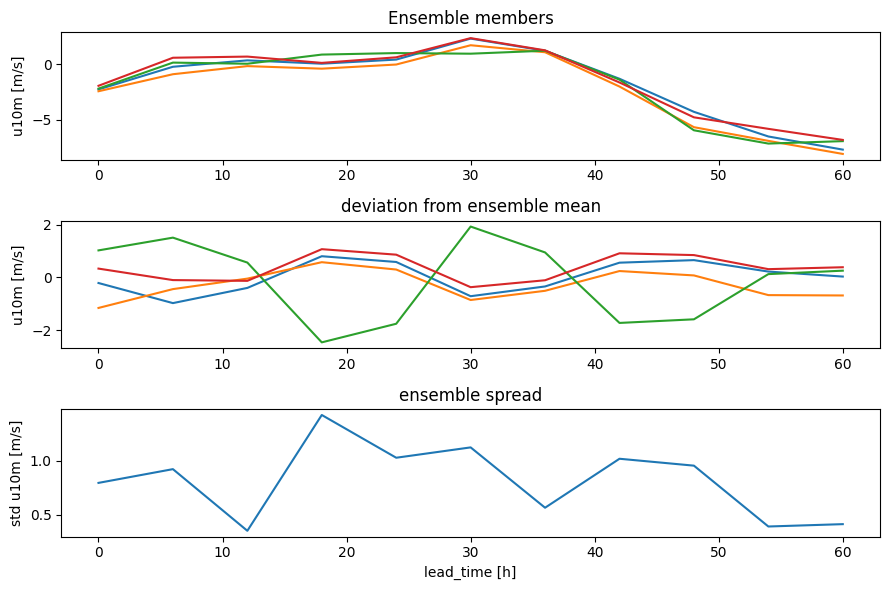

In [15]:
plt.close("all")
lead_time = np.array(
    (pd.to_datetime(ds.time) - pd.to_datetime(ds.time)[0]).total_seconds() / 3600
)
nyc_lat = 40
nyc_lon = 360 - 74
NYC = ds.sel(lon=nyc_lon, lat=nyc_lat)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(311)
ax.set_title("Ensemble members")
ax.plot(lead_time, NYC.u10m.T)
ax.set_ylabel("u10m [m/s]")

ax = fig.add_subplot(312)
ax.set_title("deviation from ensemble mean")
ax.plot(lead_time, NYC.t2m.T - NYC.t2m.mean("ensemble"))
ax.set_ylabel("u10m [m/s]")

ax = fig.add_subplot(313)
ax.set_title("ensemble spread")
ax.plot(lead_time, NYC.t2m.std("ensemble"))
ax.set_xlabel("lead_time [h]")
ax.set_ylabel("std u10m [m/s]")
plt.tight_layout()
plt.savefig(f"{output_path}/new_york_zonal_winds.png")

Next, lets plot some fields of surface temperature. Since we have an ensemble of
predictions, lets display the first ensemble member, which is deterministic member,
and also the last ensemble member and the ensemmble standard deviation. One or both of
the perturbed members may look a little noisy, thats because our noise amplitude is
maybe too high. Try lowering the amplitude in the config or changing pertibation type
to see what happens.



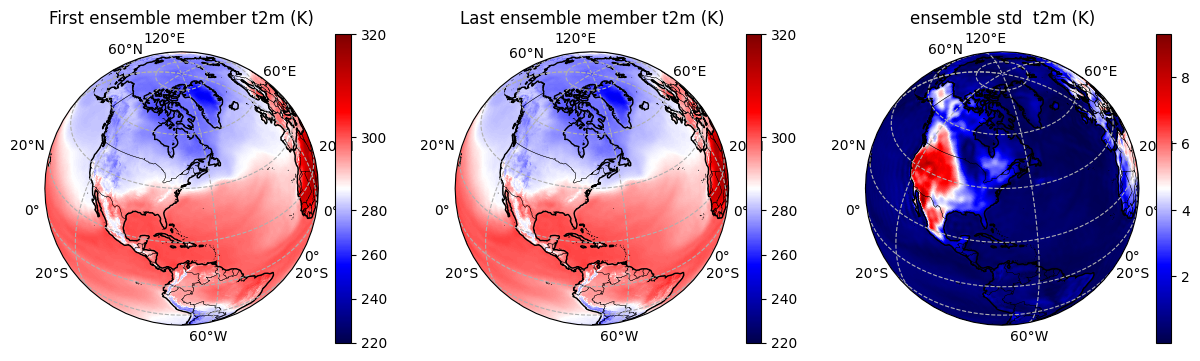

In [16]:
plt.close("all")
fig = plt.figure(figsize=(15, 10))
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

data = ds.t2m[0, -1, :, :]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(131, projection=proj)
ax.set_title("First ensemble member t2m (K)")
img = ax.pcolormesh(
    ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic"
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")

data = ds.t2m[-1, -1, :, :]
norm = TwoSlopeNorm(vmin=220, vcenter=290, vmax=320)
ax = fig.add_subplot(132, projection=proj)
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax.set_title("Last ensemble member t2m (K)")
img = ax.pcolormesh(
    ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), norm=norm, cmap="seismic"
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")

ds_ensemble_std = ds.std(dim="ensemble")
data = ds_ensemble_std.t2m[-1, :, :]
# norm = TwoSlopeNorm(vmin=data.min().values, vcenter=5, vmax=data.max().values)
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)
ax = fig.add_subplot(133, projection=proj)
ax.set_title("ensemble std  t2m (K)")
img = ax.pcolormesh(ds.lon, ds.lat, data, transform=ccrs.PlateCarree(), cmap="seismic")
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")
plt.savefig(f"{output_path}/gloabl_surface_temp_contour.png")

We can also show a map of the ensemble mean of the 10 meter zonal winds (using some
Nvidia style coloring!)



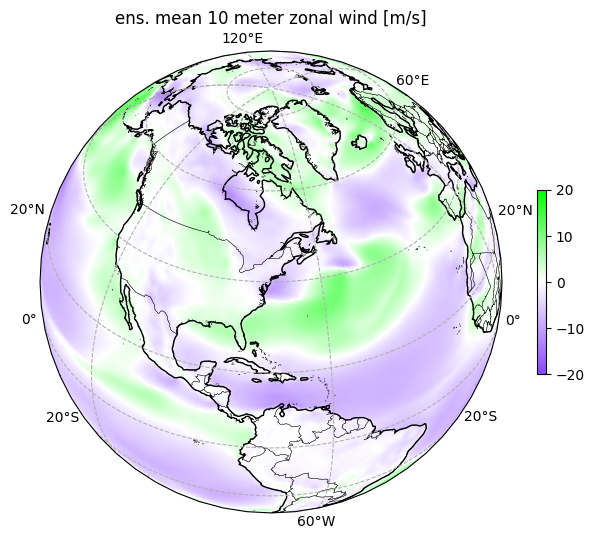

In [17]:
def Nvidia_cmap():
    colors = ["#8946ff", "#ffffff", "#00ff00"]
    cmap = mcolors.LinearSegmentedColormap.from_list("custom_cmap", colors)
    return cmap


plt.close("all")
ds_ensemble_mean = ds.mean(dim="ensemble")
data = ds_ensemble_mean.u10m[-1, :, :]
fig = plt.figure(figsize=(9, 6))
plt.rcParams["figure.dpi"] = 100
proj = ccrs.NearsidePerspective(central_longitude=nyc_lon, central_latitude=nyc_lat)

ax = fig.add_subplot(111, projection=proj)
ax.set_title("ens. mean 10 meter zonal wind [m/s]")
img = ax.pcolormesh(
    ds.lon,
    ds.lat,
    data,
    transform=ccrs.PlateCarree(),
    cmap=Nvidia_cmap(),
    vmin=-20,
    vmax=20,
)
ax.coastlines(linewidth=1)
ax.add_feature(countries, edgecolor="black", linewidth=0.25)
plt.colorbar(img, ax=ax, shrink=0.40, norm=mcolors.CenteredNorm(vcenter=0))
gl = ax.gridlines(draw_labels=True, linestyle="--")
plt.savefig(f"{output_path}/gloabl_mean_zonal_wind_contour.png")

Finally lets compute the latitude-weighted global averages and plot time series of
ensemble standard deviation.



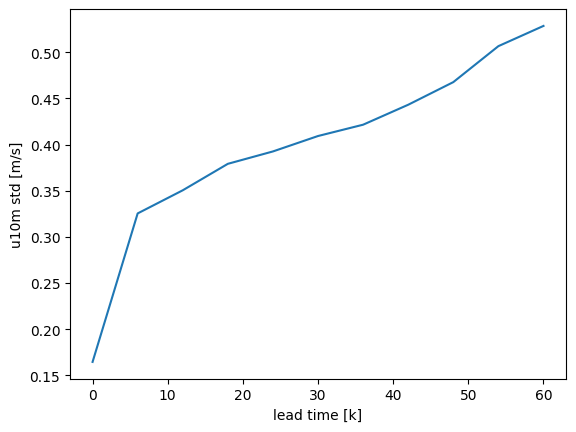

In [51]:
def global_average(ds):
    cos_lat = np.cos(np.deg2rad(ds.lat))
    #dataset_weighted = ds.weighted(cos_lat)
    #print(dataset_weighted.dims)
    return ds.weighted(cos_lat).mean(['lat']).mean(['lon'])


ds_ensemble_std = global_average(ds.std(dim="ensemble"))
plt.close("all")
plt.figure()
plt.plot(lead_time, ds_ensemble_std.u10m)
plt.xlabel("lead time [k]")
plt.ylabel("u10m std [m/s]")
plt.savefig(f"{output_path}/gloabl_std_zonal_surface_wind.png")

And that completes the introductory notebook into running ensemble weather predictions
with AI. In the next notebook, we will look at running different models using more
Pythonic APIs and plotting geopotential fields.

